In [1]:
import xml
import cv2
import subprocess
import matplotlib.pyplot as plt
import sys

from pathlib import Path


from ppadb.client import Client as AdbClient
import xml.dom.minidom
import re

import xmltodict

In [2]:
xml_annotations_path = Path("../xml_annotations/")
annotations_path = Path("../annotations/")
screenshots_path = Path("../screenshots/")

In [3]:
plt.style.use("seaborn-dark")
plt.rcParams["figure.figsize"] = 9/1.5, 16/1.5

# Process XML

In [23]:
filename = (sorted(xml_annotations_path.glob("*.xml"))[-1]).stem

In [24]:
xml_file = xml_annotations_path/f"{filename}.xml"
image_file = screenshots_path/f"{filename}.png"

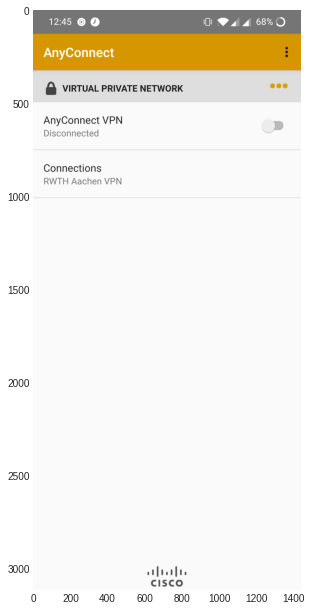

In [25]:
image = cv2.imread(str(image_file))
plt.imshow(image)

In [26]:
with open(xml_file) as fd:
    doc = xmltodict.parse(fd.read())

In [27]:
def parse_annotation(obj):
    
    def extract(obj):
        if isinstance(obj, dict):
            if "@class" in list(obj.keys()):
                # Parse widgets here                

            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item)

    try:
        extract(obj)
    except IgnoredUIException:
        raise IgnoredUIException("Ignore web view")
        pass

parse_annotation(doc)

android.widget.FrameLayout
android.widget.TextView
android.widget.ImageView
android.widget.ScrollView
android.widget.TextView
android.widget.ImageView
android.widget.LinearLayout
android.widget.LinearLayout
android.widget.TextView
android.widget.TextView
android.widget.Switch
android.widget.LinearLayout
android.widget.TextView
android.widget.TextView
